In [1]:
import openturns as ot
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt 

from shapley import SobolIndices
from skgarden import RandomForestQuantileRegressor
from sklearn.ensemble import RandomForestRegressor
from shapley.forest import compute_perm_indices, compute_shap_indices
from shapley.indices import SensitivityResults

%matplotlib inline
%load_ext autoreload
%autoreload 2

In [2]:
from shapley.tests import Ishigami
ishigami = Ishigami()
dim = ishigami.dim
model = ishigami
model.copula = ot.NormalCopula(dim)

In [3]:
%%time 
ot.RandomGenerator.SetSeed(0)
np.random.seed(0)

estimator = 'soboleff2'
n_boot = 500

n_run = 3
n_tests = 15
min_n_sample = 10
max_n_sample = 10000
all_n_sample = np.linspace(min_n_sample, max_n_sample, n_tests, dtype=int)

all_results = []
for i in range(n_run):
    sobol_results = {}
    sobol = SobolIndices(model.input_distribution)
    print('run number %d' % i)
    for n_sample in all_n_sample:
        print('n_sample: %d' % (n_sample))
        n_sample = int(n_sample)
        sobol_results[n_sample] = {}
        sobol.build_sample(model=model, n_sample=n_sample)
        sobol_results[n_sample]['monte-carlo'] = sobol.compute_indices(n_boot=n_boot, estimator=estimator)

        budget = n_sample*dim*4
        print('budget: %d' % (budget) )
        X = np.asarray(model.get_input_sample(budget, 'monte-carlo'))
        y = model(X)
        rfq = RandomForestRegressor(n_estimators=n_boot, n_jobs=7)
        rfq.fit(X, y)
        results_permutation = compute_perm_indices(rfq, X, y, model.input_distribution, indice_type='full')
        results_permutation.true_first_indices = model.first_sobol_indices
        results_permutation.true_total_indices = model.total_sobol_indices
        sobol_results[n_sample]['permutation'] = results_permutation
        
    all_results.append(sobol_results)

run number 0
n_sample: 10
budget: 120
n_sample: 723
budget: 8676
n_sample: 1437
budget: 17244
n_sample: 2150
budget: 25800
n_sample: 2864
budget: 34368
n_sample: 3577
budget: 42924
n_sample: 4291
budget: 51492
n_sample: 5005
budget: 60060
n_sample: 5718
budget: 68616
n_sample: 6432
budget: 77184
n_sample: 7145
budget: 85740
n_sample: 7859
budget: 94308
n_sample: 8572
budget: 102864
n_sample: 9286
budget: 111432
n_sample: 10000
budget: 120000
run number 1
n_sample: 10
budget: 120
n_sample: 723
budget: 8676
n_sample: 1437
budget: 17244
n_sample: 2150
budget: 25800
n_sample: 2864
budget: 34368
n_sample: 3577
budget: 42924
n_sample: 4291
budget: 51492
n_sample: 5005
budget: 60060
n_sample: 5718
budget: 68616
n_sample: 6432
budget: 77184
n_sample: 7145
budget: 85740
n_sample: 7859
budget: 94308
n_sample: 8572
budget: 102864
n_sample: 9286
budget: 111432
n_sample: 10000
budget: 120000
run number 2
n_sample: 10
budget: 120
n_sample: 723
budget: 8676
n_sample: 1437
budget: 17244
n_sample: 2150

SystemError: <built-in function Function___call__> returned a result with an error set

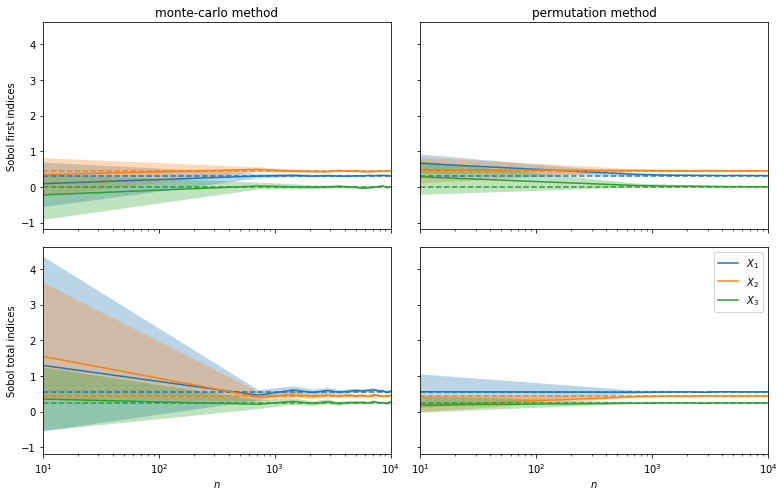

In [10]:
sobol_results = all_results[1]
fig, axes = plt.subplots(2, 2, figsize=(11, 7), sharex=True, sharey=True)
for k, method in enumerate((['monte-carlo', 'permutation'])):
    for l, indice in enumerate(['first', 'total']):
        ax = axes[l, k]
        true_indices = getattr(model, '%s_sobol_indices' % (indice))
        
        result = np.zeros((dim, n_tests, n_boot))
        for i, n_sample in enumerate(all_n_sample):
            result[:, i] = getattr(sobol_results[n_sample][method], 'full_%s_indices' % (indice))

        quantiles = np.percentile(result, [2.5, 97.5], axis=2)
        for i in range(dim):
            plot = ax.plot(all_n_sample, result[i].mean(axis=1), label='$X_%d$' % (i+1))
            ax.fill_between(all_n_sample, quantiles[0, i], quantiles[1, i], alpha=0.3)
            if model.first_sobol_indices is not None:
                ax.plot([min_n_sample, max_n_sample], [true_indices[i]]*2, '--', color=plot[0].get_color())
        if l == 0:
            ax.set_title('%s method' % (method))
        if k == 0:
            ax.set_ylabel('Sobol %s indices' % (indice))
        if l == 1:
            ax.set_xlabel('$n$')
        ax.set_xscale('log')
    
ax.set_xlim(min_n_sample, max_n_sample)
ax.legend(loc=0)        

fig.tight_layout()
fig.savefig('output/montecarlo_vs_forest_convergence.pdf')
fig.savefig('output/montecarlo_vs_forest_convergence.png')

C:\Users\naz-probook\Anaconda3\lib\site-packages\matplotlib\axes\_axes.py:545: UserWarning: No labelled objects found. Use label='...' kwarg on individual plots.
  warnings.warn("No labelled objects found. "


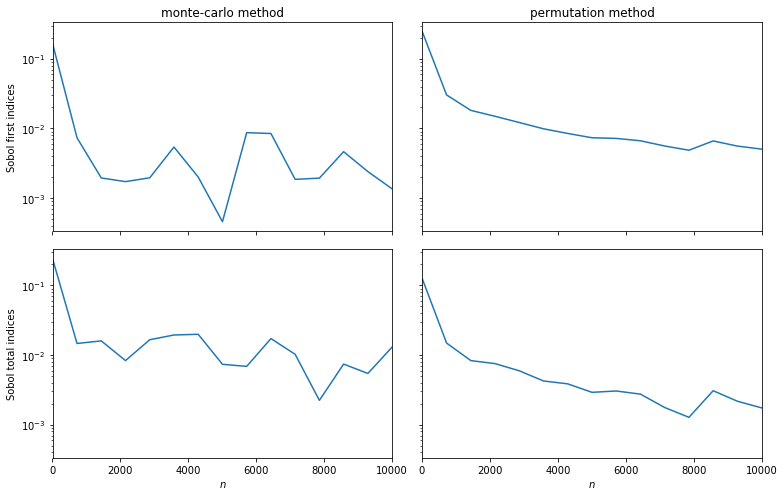

In [16]:
n_run = len(all_results)
fig, axes = plt.subplots(2, 2, figsize=(11, 7), sharex=True, sharey=True)
for k, method in enumerate((['monte-carlo', 'permutation'])):
    for l, indice in enumerate(['first', 'total']):
        ax = axes[l, k]
        true_indices = getattr(model, '%s_sobol_indices' % (indice))
        
        result = np.zeros((n_run, dim, n_tests, n_boot))
        for j, sobol_results in enumerate(all_results):
            for i, n_sample in enumerate(all_n_sample):
                result[j, :, i] = getattr(sobol_results[n_sample][method], 'full_%s_indices' % (indice))
                
        result = result.mean(axis=0)
        res = abs((result.mean(axis=2).T - true_indices).mean(axis=1))
        plot = ax.plot(all_n_sample, res)
        if l == 0:
            ax.set_title('%s method' % (method))
        if k == 0:
            ax.set_ylabel('Sobol %s indices' % (indice))
        if l == 1:
            ax.set_xlabel('$n$')
        #ax.set_xscale('log')
        ax.set_yscale('log')
    
ax.set_xlim(min_n_sample, max_n_sample)
ax.legend(loc=0)        

fig.tight_layout()
#fig.savefig('output/montecarlo_vs_forest_error.pdf')
#fig.savefig('output/montecarlo_vs_forest_error.png')

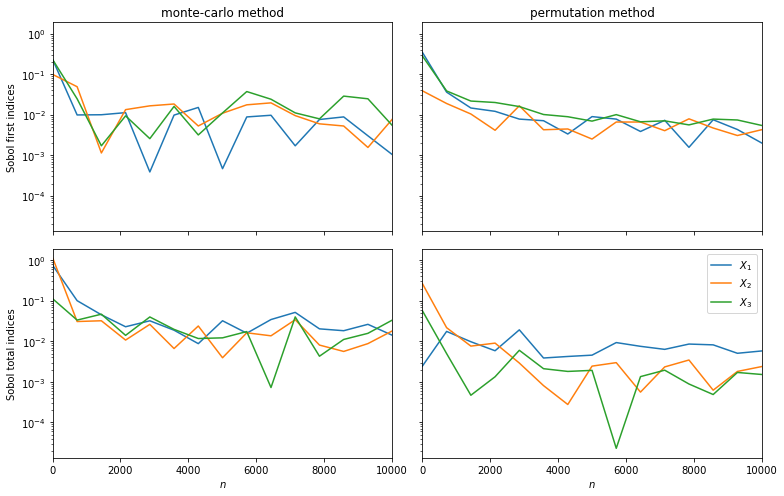

In [12]:
fig, axes = plt.subplots(2, 2, figsize=(11, 7), sharex=True, sharey=True)
for k, method in enumerate((['monte-carlo', 'permutation'])):
    for l, indice in enumerate(['first', 'total']):
        ax = axes[l, k]
        true_indices = getattr(model, '%s_sobol_indices' % (indice))
        
        result = np.zeros((dim, n_tests, n_boot))
        for i, n_sample in enumerate(all_n_sample):
            result[:, i] = getattr(sobol_results[n_sample][method], 'full_%s_indices' % (indice))

        quantiles = np.percentile(result, [2.5, 97.5], axis=2)
        for i in range(dim):
            res = result[i].mean(axis=1)
            true = true_indices[i]
            plot = ax.plot(all_n_sample, abs(res - true), label='$X_%d$' % (i+1))
            #ax.plot(all_n_sample, np.c_[abs(quantiles[0, i] - true), abs(quantiles[1, i] - true)].max(axis=1), '--')
        if l == 0:
            ax.set_title('%s method' % (method))
        if k == 0:
            ax.set_ylabel('Sobol %s indices' % (indice))
        if l == 1:
            ax.set_xlabel('$n$')
        #ax.set_xscale('log')
        ax.set_yscale('log')
    
ax.set_xlim(min_n_sample, max_n_sample)
ax.legend(loc=0)        

fig.tight_layout()
#fig.savefig('output/montecarlo_vs_forest_error.pdf')
#fig.savefig('output/montecarlo_vs_forest_error.png')

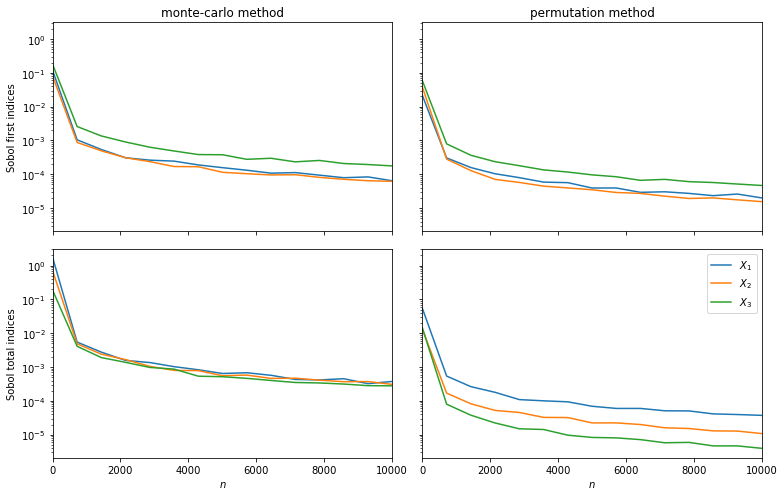

In [13]:
fig, axes = plt.subplots(2, 2, figsize=(11, 7), sharex=True, sharey=True)
for k, method in enumerate((['monte-carlo', 'permutation'])):
    for l, indice in enumerate(['first', 'total']):
        ax = axes[l, k]
        true_indices = getattr(model, '%s_sobol_indices' % (indice))
        
        result = np.zeros((dim, n_tests, n_boot))
        for i, n_sample in enumerate(all_n_sample):
            result[:, i] = getattr(sobol_results[n_sample][method], 'full_%s_indices' % (indice))

        for i in range(dim):
            cov = result[i].var(axis=1)
            plot = ax.plot(all_n_sample, cov, label='$X_%d$' % (i+1))
        if l == 0:
            ax.set_title('%s method' % (method))
        if k == 0:
            ax.set_ylabel('Sobol %s indices' % (indice))
        if l == 1:
            ax.set_xlabel('$n$')
        #ax.set_xscale('log')
        ax.set_yscale('log')
    
ax.set_xlim(min_n_sample, max_n_sample)
ax.legend(loc=0)        

fig.tight_layout()
#fig.savefig('output/montecarlo_vs_forest_error.pdf')
#fig.savefig('output/montecarlo_vs_forest_error.png')